# İş Akışı ve Hiperparametre Optimizasyonu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Ev fiyatları veri setini içe aktarın. Basitlik adına sadece sayısal özellikleri tutacağız

🎯 Hedefiniz en iyi KNN Regressor'ı yerleştirmek olacak. Özellikle, ev fiyatlarınız için en iyi tahminleri elde etmek üzere kaç tane "komşu" (<font color=blue>K</font>NN'deki <font color=blue>K</font>) göz önünde bulundurmalısınız?

In [2]:
# Load raw data
data = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Eğitim/Test Ayrımı

❓ **Soru (Holdout)**❓

👇 `X_train`, `X_test`, `y_train` ve `y_test` oluşturmak için veri setini böl. Şunları kullan:
- `test_size=0.3`
- Sonuçlarınızı arkadaşınızla karşılaştırmak için `random_state=0`

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Ölçeklendirme

⚖️ Ölçeklendirme KNN algoritması için her zaman kritik derecede önemlidir..

❓ **Soru (Ölçeklendirme)** ❓ 

* Eğitim setinizi ve test setinizi ölçeklendirin.
* Burada, basitçe `StandardScaler` uygulayalım ve özellik başına bir ölçekleyici seçerek zaman kaybetmeyelim. Gerçekten de, bu egzersizin amaçları şunlardır:
    * KNN'i gözden geçirmek
    * GridSearchCV'yi anlamak
    * RandomizedSearchCV'yi anlamak

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Temel KNN modeli

❓ **Soru (KNN için bir temel)** ❓

Sadece _en yakın komşuyu_ dikkate alan basit bir KNN regressor'ı çapraz doğrulayın (*cv = 5*) ve 5 kat üzerindeki ortalama skoru hesaplayın.

In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

knn_baseline = KNeighborsRegressor(n_neighbors=1)

cv_scores = cross_val_score(knn_baseline, X_train_scaled, y_train, cv=5)

print(f"CV Scores for K=1: {cv_scores}")
print(f"Mean Score for K=1: {cv_scores.mean()}")


CV Scores for K=1: [0.54270115 0.68418625 0.25016271 0.77858198 0.54513935]
Mean Score for K=1: 0.5601542887874071


## 4. GridSearch

### 4.1. İlk GridSearch

❓ **Soru (GridSearch v1)**❓

En iyi KNN hiperparametresini `n_neighbors` bulmak için SKLearn `GridSearchCV` kullanalım.
- `n_neighbors` = [1,5,10,20,50] ile kaba taneli bir yaklaşım başlat
- Her parametreyi 5-kat çapraz doğrula
- `n_jobs` kullanarak performans sürenizi maksimize ettiğinizden emin olun

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instantiate model
knn = KNeighborsRegressor()


# Hyperparameter Grid
grid_v1 = {'n_neighbors': [1, 5, 10, 20, 50]}


# Instantiate Grid Search
search_v1 = GridSearchCV(knn, grid_v1, cv=5, n_jobs=-1)


# Fit data to Grid Search
search_v1.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]})

❓ **Soru (en iyi parametreler)** ❓

GridSearch'e göre, optimal K değeri nedir?

In [11]:
# Best K value
print(f"Best K value from Grid Search v1: {search_v1.best_params_}")
best_k_v1 = search_v1.best_params_['n_neighbors']

Best K value from Grid Search v1: {'n_neighbors': 10}


❓ **Soru (puanlama)** ❓ Optimal K değerinin ürettiği en iyi skor nedir?

In [12]:
# Best score
print(f"Best CV Score from Grid Search v1: {search_v1.best_score_}")
best_score_v1 = search_v1.best_score_

Best CV Score from Grid Search v1: 0.7596697382171873


### 4.2. İkinci GridSearch

❓ **Soru (GridSearch V2)** ❓

Şimdi, en iyi $K$'nın nerede olduğu hakkında bir fikrimiz var, ancak denemediğimiz bazı değerler daha iyi bir performansla sonuçlanabilir.

* Önceki en iyi değerinizin çevresindeki $K$ için bazı değerleri deneyerek GridSearch'ü yeniden çalıştırın
* Bu rafine edilmiş GridSearch için `best_score` ve `best_k` nelerdir?

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Instantiate model
knn = KNeighborsRegressor()

# Hyperparameter Grid
n_range = list(range(15, 100))
grid_v2 = {'n_neighbors': n_range}

# Instantiate Grid Search
search_v2 = GridSearchCV(knn, grid_v2, cv=5, n_jobs=-1)

# Fit data to Grid Search
search_v2.fit(X_train_scaled, y_train)

print (f"Best K value from Grid Search v2: {search_v2.best_params_}")
best_k = search_v2.best_params_['n_neighbors']

print (f"Best CV Score from Grid Search v2: {search_v2.best_score_}")
best_score = search_v2.best_score_

Best K value from Grid Search v2: {'n_neighbors': 16}
Best CV Score from Grid Search v2: 0.7666311417513013


***🧪 Kodunuzu test edin***

In [14]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/D16D5-S-data-workflow/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.10s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Görsel kontrol (manuel GridSearch)

☝️ Bu problem aslında manuel olarak GridSearch yapmak için yeterince basittir.

❓ **Soru(Manuel GridSearch)** ❓

- $K$'nın $1$'den $50$'ye kadar tüm değerleri üzerinde manuel olarak döngü yapın ve her modelin çapraz doğrulanmış skorlarının ortalamasını bir listede saklayın.
- `Dirsek Yöntemi` kullanarak en iyi $K$'yı görsel olarak bulmak için skorları $K$'nın bir fonksiyonu olarak çizin

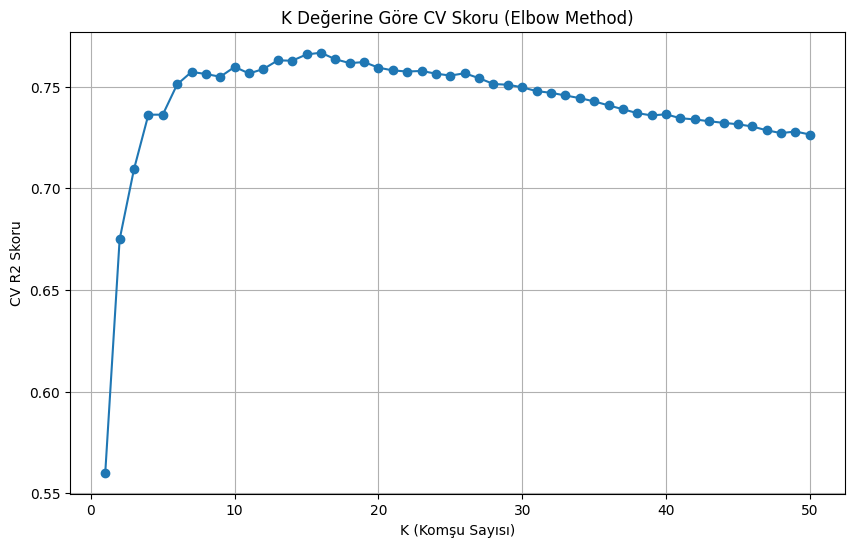

In [15]:
k_values = range(1, 51)
scores = []

for k in k_values:
    knn_temp = KNeighborsRegressor(n_neighbors=k)
    score = cross_val_score(knn_temp, X_train_scaled, y_train, cv=5).mean()
    scores.append(score)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o')
plt.title('K Değerine Göre CV Skoru (Elbow Method)')
plt.xlabel('K (Komşu Sayısı)')
plt.ylabel('CV R2 Skoru')
plt.grid(True)
plt.show()

❓GridSearchCV'yi böyle bir manuel döngüden daha iyi bir seçenek yapan şeyi tahmin edebilir misiniz?

<details>
    <summary>Cevap</summary>

- Sklearn'ın `n_jobs=-1` seçeneği aramayı paralelleştirmenize izin verir, tüm CPU çekirdeklerinizi kullanır
- Birlikte optimize edilecek birden fazla hiperparametreniz olsaydı ne olurdu?
</details>

## 5. Birden çok parametre ile GridSearch

👩🏻‍🏫 KNNRegressor, `p` hiperparametresi aracılığıyla çeşitli _mesafe metrikleri_ destekler

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Soru (birden çok parametreyi ayarlama)** ❓

* En iyi $K$ ve $p$'yi aynı anda aramak için GridSearchCV kullanın.
    * $K = [1, 5, 10, 20, 50]$ ve $p = [1, 2, 3]$ için tüm kombinasyonları deneyin.

In [23]:
grid_multi = {
    'n_neighbors': [1, 5, 10, 20, 50],  
    'p': [1, 2, 3] # Manhattan, Euclidean, Minkowski
}

search_multi = GridSearchCV(knn, grid_multi, cv=5, n_jobs=-1)
search_multi.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50], 'p': [1, 2, 3]})

❓ **Soru (alt model sayısı)**❓

Toplamda kaç alt model eğittiniz?

<details>
    <summary>İpucu</summary>

15'ten çok daha fazla. İki kez düşün :)
    <details>
    <summary>Cevap</summary>

CV=5 nedeniyle 75 model
</details>

In [24]:
print (5 * 3 * 5)

75


❓ **Soru (modeli birden çok parametre ile ayarladıktan sonra en iyi parametreler ve en iyi skor)**❓

*En iyi parametreler* ve *en iyi skor* nedir?

In [25]:
print(f"Best parameters from Multi-parameter Grid Search: {search_multi.best_params_}")
print(f"Best CV Score from Multi-parameter Grid Search: {search_multi.best_score_}")

Best parameters from Multi-parameter Grid Search: {'n_neighbors': 10, 'p': 1}
Best CV Score from Multi-parameter Grid Search: 0.7969255879201194


## 6. Rastgele Arama

Şimdi bir RandomizedSearch'ün aynı sayıda model yerleştirilerek daha iyi bir kombinasyon bulup bulamayacağını görelim.

❓ **Soru (RandomizedSearchCV)** ❓

`RandomizedSearchCV` kullanarak
- $K$'yı uniform `scipy.stats.randint(1,50)` ([döküman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) dağılımından rastgele örnekle
- $p$'yi $[1,2,3]$ listesinden örnekle
- Önceki GridSearchCV'nizdeki ile tam olarak aynı sayıda model yerleştirmek için doğru `n_iter` ve `cv` sayılarını kullanın.

In [26]:
from scipy.stats import randint

param_dist = {
    'n_neighbors': randint(1, 50),
    'p': [1, 2, 3]
}

random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=1)
random_search.fit(X_train_scaled, y_train)

print(f"Best parameters from Randomized Search: {random_search.best_params_}")
print(f"Best CV Score from Randomized Search: {random_search.best_score_}")

Best parameters from Randomized Search: {'n_neighbors': 6, 'p': 1}
Best CV Score from Randomized Search: 0.7978787384801239


## 7. Genelleme

❓ **Soru (modelinizi bir kez daha ince ayarlama)**❓

- İsterseniz RandomsearchCV'nizi rafine edin
- En iyi modelinizi seçin

In [27]:
best_model = random_search.best_estimator_

Şimdi `cv_results`'ınızı bir `DataFrame` olarak görüntülemeye çalışın, bu CV'nin içinde neler olup bittiğini görselleştirmenize yardımcı olacak! 😉

In [29]:
results_df = pd.DataFrame(random_search.cv_results_)
print(results_df[['params', 'mean_test_score']].head())

                        params  mean_test_score
0  {'n_neighbors': 38, 'p': 1}         0.759332
1   {'n_neighbors': 9, 'p': 2}         0.754820
2  {'n_neighbors': 12, 'p': 2}         0.758630
3  {'n_neighbors': 16, 'p': 1}         0.782462
4  {'n_neighbors': 17, 'p': 2}         0.763425


❓ **Soru ("En iyi" modelin değerlendirmesi)** ❓

* "En iyi parametrelerle" modelimizin **görülmemiş** test seti `X_test` üzerindeki performansını keşfetme zamanı geldi.
    * Test seti için r2 skorunu hesaplayın ve `r2_test` olarak kaydedin.

In [30]:
y_pred = best_model.predict(X_test_scaled)

from sklearn.metrics import r2_score
r2_test = r2_score(y_test, y_pred)

print(f"R2 Skoru: {r2_test}")

R2 Skoru: 0.7849037111368564


❓ **Soru (Bir adım geri çekilme)** ❓

Optimize edilmiş modelin iyi genelleme yaptığını düşünür müsünüz?

<details><summary>Cevap</summary>

Test skoru eğitim seti ile biraz azalabilir. Muhtemelen %5'ten fazla değil. Bunun nedeni şunlar olabilir:
- Temsili olmayan bir eğitim/test bölünmesi
- Model ayarlama aşamasında aşırı öğrenmeye yol açan çok küçük bir çapraz doğrulama sayısı. Ne kadar çok çapraz doğrulama yaparsanız, bulgularınız o kadar güçlü genelleşir - ancak veri setiniz çok küçükse cv'yi çok fazla artıramazsınız çünkü her katmanda temsili olmak için yeterli gözlemi tutamazsınız.
- Veri setimiz çok küçük ve hiperparametre optimizasyonumuz bu nedenle eğitim/test bölünmemize son derece bağımlı (ve aşırı uyum gösteriyor). Veri setinizin denediğiniz toplam hiperparametre kombinasyonu sayısından çok daha büyük olduğundan her zaman emin olun!
    
</details>

***🧪 Kodunuzu test edin***

In [31]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/berkayturhan/.pyenv/versions/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/berkayturhan/D16D5-S-data-workflow/tests
plugins: dash-3.3.0, anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_r2.py::TestR2::test_r2 PASSED                                       [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/r2.pickle

git commit -m 'Completed r2 step'

git push origin master



🏁 Tebrikler! Artık GridSearchCV veya RandomizedSearchCV kullanarak bir modeli nasıl ince ayarlayacağınızı biliyorsunuz

💾 Notebook'unuzu `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki meydan okumaya geçin!